In [1]:
import sys
path = "../../.."
if path not in sys.path:
    sys.path.insert(0, path)

In [17]:
from data_retrieval import lipade_groundtruth
from PIL import Image
from transformers import FlavaImageProcessor, FlavaImageModel
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
corpus = "lipade_groundtruth"
rawPath = "../results/raw/" + corpus + "/"
distancePath = "../results/distance/" + corpus + "/"

model = FlavaImageModel.from_pretrained("facebook/flava-full")
feature_extractor = FlavaImageProcessor.from_pretrained("facebook/flava-full")

In [ ]:
x,_,y = lipade_groundtruth.getDataset(mode="similar")
for i in range(len(x)):
    x[i] = Image.open(x[i]).convert('RGB')

In [ ]:
def getEmbedding(img):
    input = feature_extractor(images=[img], return_tensors="pt")
    return model(**input).last_hidden_state.detach().numpy()

embeddings = np.array([getEmbedding(img) for img in tqdm(x)]).reshape(len(x), -1)

distance = 1 - (cosine_similarity(embeddings, embeddings)+1)/2
distance -= np.diag(distance)

In [ ]:
np.save(rawPath + "flava.npy", embeddings)
np.save(distancePath + "flava.npy", distance)

# Re-entrainement

In [2]:
from data_retrieval import lipade_groundtruth
from PIL import Image
from transformers import FlavaImageProcessor, FlavaImageModel
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from data_retrieval.tools.data_loader import getDataLoader
from torch.utils.data import DataLoader
import torch.optim as optim
import clustering.evaluators as evaluators


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


temperature = 0.5
learningRate = 1e-3
batch_size = 128


corpus = "lipade_groundtruth"
rawPath = "../results/raw/" + corpus + "/"
distancePath = "../results/distance/" + corpus + "/"

model = FlavaImageModel.from_pretrained("facebook/flava-full")
feature_extractor = FlavaImageProcessor.from_pretrained("facebook/flava-full")

x,_,y = lipade_groundtruth.getDataset(mode = 'unique', uniform=True)

for i in range(len(x)):
    try:
        x[i] = Image.open(x[i]).convert('RGB')
    except:
        print("Error loading image:", x[i])

images = np.array(x)

def infoNCEloss(z1, z2, t=1): # loss 1
    z = torch.cat([z1, z2], dim=0)

    s = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1)
    exp_s = torch.exp(s / t)
    indicatorMask = torch.eye(s.shape[0], dtype=torch.bool, device=z.device) # True on diagonal, False elsewhere
    exp_s = exp_s.masked_fill(indicatorMask, 0)

    numerator = F.cosine_similarity(z1, z2, dim=-1)      # for z1
    numerator = torch.cat([numerator, numerator], dim=0) # for z2
    numerator = torch.exp(numerator / t)

    denominator = exp_s.sum(dim=1)

    l = -torch.log(numerator / denominator)
    return l.mean()



from degradations.methods import transforms_atkinson_dithering, transforms_bayer_halftoning, transforms_floyd_steinberg_halftoning, transforms_drawing, transforms_erased_element, transforms_paint, transforms_non_rectangular_frame, transforms_patchwork, transforms_photo_montage, transforms_picture_overlay, transforms_text_overlay, transforms_dirty_rollers, transforms_add_gaussian_noise, transforms_add_salt_and_pepper_noise, transforms_bleedthrough, transforms_contrast, transforms_crumpled_paper, transforms_folded_paper, transforms_ink_bleed, transforms_book, transforms_stains, transforms_scribbles, transforms_torn_paper

class transforms_SepiaFilter(nn.Module):
    def __init__(self):
        super(transforms_SepiaFilter, self).__init__()

    def __call__(self, batch):
        sepia_filter = torch.tensor([[0.393, 0.769, 0.189],
                                     [0.349, 0.686, 0.168],
                                     [0.272, 0.534, 0.131]], device=batch.device)
        batch = torch.einsum('ijkl,mj->imkl', batch, sepia_filter)
        return batch.clamp(0, 1)


transform_1by1 = transforms.Compose([
        transforms.RandomChoice([
            transforms.RandomResizedCrop(size=images.shape[2], scale=(1/2, 1), ratio=(1, 1)),
            transforms_floyd_steinberg_halftoning(),
            transforms_atkinson_dithering(),
            transforms_bayer_halftoning(),
            transforms_picture_overlay(),
            transforms_text_overlay(),
            transforms_torn_paper(),
            #transforms_erased_element(),
            transforms_add_gaussian_noise(),
            transforms_add_salt_and_pepper_noise(),
            transforms_dirty_rollers(),
            transforms_stains(),
            transforms_ink_bleed(),
            transforms_bleedthrough(),
            transforms_crumpled_paper(),
            transforms_folded_paper(),
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomVerticalFlip(p=1),
            transforms_SepiaFilter()]),
        transforms.ColorJitter(brightness=0.8, contrast=0.8, saturation=0.8, hue=0.2),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
])


trainLoader = getDataLoader(images, None, None, False, batch_size, True, num_workers=2)


In [ ]:
import psutil
print(psutil.cpu_percent())
print(psutil.virtual_memory())
dict(psutil.virtual_memory()._asdict())
print("RAM used",psutil.virtual_memory().percent)
print("available memory", psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim



model.gradient_checkpointing_enable()
#model = model.to(device)


optimizer = optim.AdamW(model.parameters(), lr=1e-4) # test 1/2 : lr=1e-5

for epoch in range(10):
    loss_epoch = []
    for batch in tqdm(trainLoader):

        x_2 = transform_1by1(batch) #.to(device)
        x = batch #.to(device)
        x_2 = torch.clamp(x_2, min=0.0, max=1.0)

        input1 = feature_extractor(images=x, return_tensors="pt",do_rescale=False)
        #input1 = {k: v.to(device) for k, v in input1.items()}
        z1 = model(**input1).pooler_output 

        input2 = feature_extractor(images=x_2, return_tensors="pt",do_rescale=False)
        #input2 = {k: v.to(device) for k, v in input2.items()}
        z2 = model(**input2).pooler_output 


        # x = batch.to(device) -> test 1
        # x_2 = transform_1by1(x.cpu()).to(device) -> test 1

        # input1 = feature_extractor(images=[x], return_tensors="pt",do_rescale=False) -> test 1
        # z1 = model(**input1).last_hidden_state -> test 1
        # z1 = z1.reshape(z1[0], -1) -> test 1

        # input2 = feature_extractor(images=[x_2], return_tensors="pt",do_rescale=False) -> test 1
        # z2 = model(**input2).last_hidden_state -> test 1
        # z2 = z2.reshape(z2[0], -1) -> test 1


        # with torch.cuda.amp.autocast(): -> test 2
        loss = infoNCEloss(z1, z2, temperature)

        #loss = infoNCEloss(z1, z2, temperature) # ?????????????????????????
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch.append(loss.item())
    torch.save(model.state_dict(), f"flava_test3.pth")

    print(f"Epoch {epoch+1} | Loss: {np.mean(loss_epoch):.4f}")



100%|██████████| 46/46 [57:58<00:00, 75.61s/it] 


Epoch 1 | Loss: 4.4084


100%|██████████| 46/46 [1:10:50<00:00, 92.40s/it] 


Epoch 2 | Loss: 3.9718


100%|██████████| 46/46 [1:10:05<00:00, 91.42s/it] 


Epoch 3 | Loss: 3.9167


100%|██████████| 46/46 [1:11:03<00:00, 92.69s/it] 


Epoch 4 | Loss: 3.8477


100%|██████████| 46/46 [1:10:47<00:00, 92.33s/it] 


Epoch 5 | Loss: 3.9232


100%|██████████| 46/46 [1:07:44<00:00, 88.35s/it]


Epoch 6 | Loss: 4.0147


100%|██████████| 46/46 [1:05:39<00:00, 85.65s/it] 


Epoch 7 | Loss: 3.8684


100%|██████████| 46/46 [1:04:16<00:00, 83.84s/it]


Epoch 8 | Loss: 3.7948


100%|██████████| 46/46 [54:12<00:00, 70.71s/it] 


Epoch 9 | Loss: 3.7880


100%|██████████| 46/46 [1:09:10<00:00, 90.22s/it] 


Epoch 10 | Loss: 3.7939


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.
Thresholds: 100%|██████████| 100/100 [00:01<00:00, 56.22it/s]

0.03930764144825161 0.19160583941605838 0.18064716642690962 0.029940119760479042
f1: 0.029940119760479042


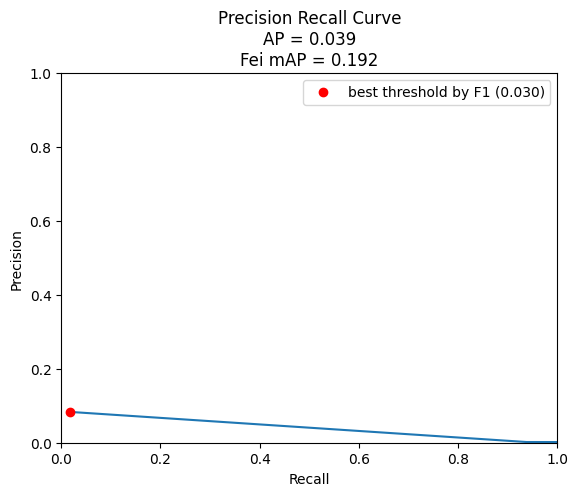

In [4]:
# Test
xSim,_,ySim = lipade_groundtruth.getDataset(mode = 'similar', uniform=True)
_,_,y_test = lipade_groundtruth.getDataset(mode="similar")

imagesSim = []
for i in range(len(xSim)):
    try:
        imagesSim.append(Image.open(xSim[i]).convert('RGB'))
    except:
        print("Error loading image:", xSim[i])

testLoader = getDataLoader(imagesSim, None, None, False, batch_size, shuffle=False, num_workers=2)

# Test 
representations = []
with torch.no_grad():
    for batch in testLoader:
        input = feature_extractor(images=batch, return_tensors="pt")
        batch = model(**input).pooler_output #.last_hidden_state
        #batch = batch.reshape(batch.shape[0], -1)

        for repr in batch.tolist():
            representations.append(repr)

sim = cosine_similarity(representations, representations)

distance = 1 - (sim+1)/2
distance -= np.diag(distance)

np.save(distancePath + f"flava_test3.npy", distance)

method = f"flava_test3"

thresholds_precision = 1000
thresholds = np.linspace(0, 1, thresholds_precision)

precisions, recalls, f1s = evaluators.p_r_f1_byThresholds(thresholds, distance, y_test)
f1 = np.max(f1s)
AP, bestThresholdIndex = evaluators.pr_curve(precisions, recalls, f1s, other=("Fei mAP", evaluators.fei_mAP(y_test, distance)), save="/home/renard/highvision/clustering/evaluation/" + corpus + "/" + method + ".png")

thresholdsClass = np.linspace(0, 1, int(thresholds_precision / 10))
precisions_per_class, recalls_per_class = evaluators.p_r_class_byThresholds(thresholdsClass, distance, y_test)
fei = evaluators.fei_mAP(y_test, distance)
sam = evaluators.goncalves_mAP(precisions_per_class, recalls_per_class)



print(AP, fei, sam, f1)
print("f1:", f1)